[Reference](https://medium.com/analytics-vidhya/keras-lstm-forecasting-using-synthetic-data-9e1ae4e07d47)

In [1]:
import datetime
import numpy as np
import os
import sys
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(sys.version)

2.8.0
3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]


In [1]:
!pip install pandas==1.1.5 # requires Runtime restart
!pip install scikit-learn==1.0 # requires Runtime restart
import pandas as pd
# assert pd.__version__ == "1.1.5"
pd.set_option("max_columns", 100)
import sklearn
assert sklearn.__version__ == "1.0"
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import make_friedman1, make_regression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [7]:
import numpy as np
import datetime

np.random.seed(1)
forecast_steps = 7 # 7

def generate_data():
    df = pd.DataFrame()
    start_date = datetime.datetime(year=2001, month=1, day=1)
    df["date"] = [start_date + datetime.timedelta(days=x+1) for x in range(365*15)]
    num_features = 10 # only 5 features determine label
    n_informative = 5 # determine the label, the rest is random
    X, y = make_friedman1(n_samples=df.shape[0], n_features=num_features, noise=1.0)
    # X, y = make_regression(n_samples=df.shape[0], n_features=num_features, n_informative=n_informative, n_targets=1)
    df.loc[:, [f"x_{i}" for i in range(num_features)]] = X
    df.loc[:, "x_2"] *= 20 # scale feature
    df.loc[:, "x_3"] *= 30 # scale feature
    df.loc[:, "x_7"] *= 70 # scale feature
    df.loc[:, "x_8"] *= 80 # scale feature
    df.loc[:, "y"] = y
    df.loc[:, "y"] = (
        0.5 * df.loc[:, "y"] +
        0.5 * df.loc[:, "y"].rolling(window=3).mean()
    )
    df.loc[:, "y"] = df.loc[:, "y"].shift(forecast_steps)
    df.rolling(2, min_periods=1).sum()
    return df
df = generate_data()
df.describe(include="all", datetime_is_numeric=True)

,date,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y
count,5475,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5475.000000,5466.000000
mean,2008-07-01 00:00:00.000029184,0.499200,0.500893,9.947641,14.926298,0.502209,0.501965,0.491453,35.024637,39.932751,0.506453,14.366396
min,2001-01-02 00:00:00,0.000084,0.000079,0.002287,0.001414,0.000072,0.000248,0.000079,0.017472,0.000830,0.000011,3.783890
25%,2004-10-01 12:00:00,0.251183,0.244304,4.976404,7.273625,0.252892,0.248793,0.239705,17.336051,20.410696,0.249481,11.948152
50%,2008-07-01 00:00:00,0.491677,0.504741,9.950743,14.968018,0.506688,0.500906,0.492554,35.429179,39.796218,0.519164,14.439272
75%,2012-03-30 12:00:00,0.747067,0.758768,14.887439,22.626872,0.751767,0.759172,0.737345,52.544612,59.656927,0.755871,16.754376
max,2015-12-29 00:00:00,0.999754,0.999834,19.995147,29.995535,0.999900,0.999990,0.999660,69.967756,79.957545,0.999813,24.853195
std,NaN,0.285983,0.291814,5.760796,8.751435,0.288316,0.289881,0.287323,20.240193,22.963125,0.289597,3.484810


In [8]:
df.head(10)

,date,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y
0,2001-01-02,0.417022,0.720324,0.002287,9.069977,0.146756,0.092339,0.186260,24.189251,31.741398,0.538817,NaN
1,2001-01-03,0.419195,0.685220,4.089045,26.343523,0.027388,0.670468,0.417305,39.108288,11.230955,0.198101,NaN
2,2001-01-04,0.800745,0.968262,6.268484,20.769678,0.876389,0.894607,0.085044,2.733835,13.586434,0.878143,NaN
3,2001-01-05,0.098347,0.421108,19.157791,15.994959,0.691877,0.315516,0.686501,58.423797,1.463062,0.750144,NaN
4,2001-01-06,0.988861,0.748166,5.608880,23.678380,0.103226,0.447894,0.908596,20.552990,23.022027,0.130029,NaN
5,2001-01-07,0.019367,0.678836,4.232562,7.966400,0.491573,0.053363,0.574118,10.271000,47.144443,0.699758,NaN
6,2001-01-08,0.102334,0.414056,13.888003,12.425378,0.049953,0.535896,0.663795,36.042238,75.567580,0.586555,NaN
7,2001-01-09,0.903402,0.137475,2.785527,24.221739,0.397677,0.165354,0.927509,24.343610,60.064968,0.725998,NaN
8,2001-01-10,0.883306,0.623672,15.018849,10.466950,0.269928,0.895886,0.428091,67.538803,53.075320,0.621696,NaN
9,2001-01-11,0.114746,0.949489,8.998243,17.351688,0.408137,0.237027,0.903380,40.157564,0.229626,0.617145,16.564334


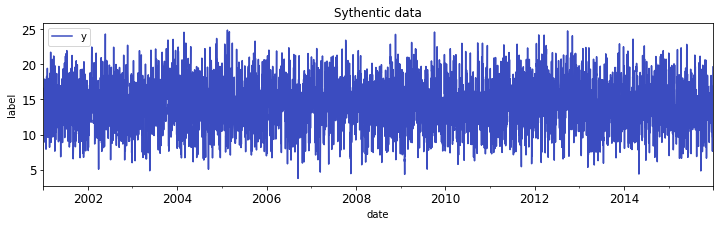

In [9]:
df.plot(kind="line", 
        x="date", 
        y="y", 
        colormap="coolwarm", 
        figsize=(12, 3), 
        fontsize=12,
        title="Sythentic data",
        xlabel="date", 
        ylabel="label")

In [10]:
df_corr = df.copy(deep=True)
df_corr.loc[:, "future_label"] = df_corr.loc[:, "y"].shift(-forecast_steps)
df_corr.corr().style.background_gradient(cmap="coolwarm")

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y,future_label
x_0,1.000000,-0.011230,-0.008236,-0.003817,0.008050,-0.007087,-0.005471,-0.018666,0.002469,-0.007974,0.013433,0.343410
x_1,-0.011230,1.000000,0.013938,-0.022951,0.007660,0.001471,-0.005772,0.007867,0.000011,-0.001630,-0.000411,0.367546
x_2,-0.008236,0.013938,1.000000,-0.005004,-0.010491,-0.003633,0.017680,-0.018911,-0.017886,0.010443,-0.012752,-0.004859
x_3,-0.003817,-0.022951,-0.005004,1.000000,-0.009876,0.036063,-0.010286,-0.002176,-0.009020,0.007870,-0.007557,0.543532
x_4,0.008050,0.007660,-0.010491,-0.009876,1.000000,0.007150,0.027339,-0.005743,0.009159,0.006346,0.011170,0.280323
x_5,-0.007087,0.001471,-0.003633,0.036063,0.007150,1.000000,-0.017550,0.018368,-0.009455,0.010404,0.026603,0.013868
x_6,-0.005471,-0.005772,0.017680,-0.010286,0.027339,-0.017550,1.000000,0.001568,-0.018141,-0.017902,0.007078,-0.003980
x_7,-0.018666,0.007867,-0.018911,-0.002176,-0.005743,0.018368,0.001568,1.000000,-0.006124,-0.016254,-0.014022,-0.006538
x_8,0.002469,0.000011,-0.017886,-0.009020,0.009159,-0.009455,-0.018141,-0.006124,1.000000,-0.019908,-0.005104,0.009448
x_9,-0.007974,-0.001630,0.010443,0.007870,0.006346,0.010404,-0.017902,-0.016254,-0.019908,1.000000,0.012354,-0.002757


In [11]:
lookback_steps = 14 # length of history provided to learn label at t
end_train_idx = int(0.7 * df.shape[0])
end_validation_idx = int(0.85 * df.shape[0])
print(f"""train idx: [{df.index[0]}, {end_train_idx})
validation idx: [{end_train_idx}, {end_validation_idx})
test idx: [{end_validation_idx}-{df.shape[0]})""")

train idx: [0, 3832)
validation idx: [3832, 4653)
test idx: [4653-5475)


In [12]:
# label 'y' is included as a feature because historical labels are provided as features
numerical_features = ["y"] + [f"x_{i}" for i in range(10)]

In [13]:
def get_feature_pipeline():
    class FeatureSelector(BaseEstimator, TransformerMixin):
        def __init__(self, feature_names):
            self.feature_names = feature_names   
        def fit( self, X, y = None ):
            return self
        def transform(self, X, y=None):
            return X.loc[:, self.feature_names].copy(deep=True)
    numerical_pipeline = Pipeline(steps = [ 
        ("num_selector", FeatureSelector(numerical_features)),
        ("imputer", SimpleImputer(strategy="median")),
        ("std_scaler", StandardScaler()) 
    ])
    feature_pipeline = FeatureUnion(
        n_jobs=1, 
        transformer_list=[ 
            ("numerical_pipeline", numerical_pipeline),
            # ("categorical_pipeline", categorical_pipeline),
        ]
    )
    return feature_pipeline

In [14]:
feature_pipeline = get_feature_pipeline()
train_df = pd.DataFrame(
    feature_pipeline.fit_transform(
        df.loc[:end_train_idx, :]
    ), 
    columns=numerical_features
)
# Train label is offset by the number of steps into the future we're forecasting
train_df.loc[:, "label"] = train_df.loc[:, "y"].shift(-forecast_steps)
train_df = train_df.loc[train_df["label"].notna(), :]
assert 0 == train_df.isna().sum().sum()
print(train_df.shape)
train_df.head(5)

(3826, 12)


,y,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,label
0,0.019987,-0.281535,0.743078,-1.732444,-0.670609,-1.240892,-1.392544,-1.048232,-0.518341,-0.363001,0.105768,0.019987
1,0.019987,-0.273918,0.623383,-1.021729,1.306435,-1.656933,0.605012,-0.244852,0.215292,-1.254779,-1.065334,0.019987
2,0.019987,1.063775,1.588445,-0.642710,0.668480,1.302139,1.379459,-1.400177,-1.573396,-1.152365,1.272093,0.638336
3,0.019987,-1.398792,-0.277134,1.598828,0.121990,0.659049,-0.621421,0.691189,1.165119,-1.679479,0.832140,0.263882
4,0.019987,1.723301,0.838005,-0.757420,1.001396,-1.392609,-0.164027,1.463449,-0.697151,-0.742112,-1.299313,1.021163


In [18]:
from tensorflow import keras
from tensorflow.keras import layers

In [19]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    data=train_df.loc[:train_df.shape[0]-lookback_steps, numerical_features],
    targets=train_df.loc[lookback_steps-1:, "label"],
    sequence_length=lookback_steps,
    sequence_stride=1,
    sampling_rate=1,
    batch_size=256,
    shuffle=False,
)
for x, y in dataset_train.take(1):
    print(x.shape, y.shape)

(256, 14, 11) (256,)


In [20]:
def df_transform_to_keras_dataset(df_idx_start, df_idx_end):
    validation_df = pd.DataFrame(
        feature_pipeline.transform(
            df.loc[df_idx_start:df_idx_end, :]
        ), 
        columns=numerical_features
    )
    validation_df.loc[:, "label"] = validation_df.loc[:, "y"].shift(-forecast_steps)
    validation_df = validation_df.loc[validation_df["label"].notna(), :]
    assert 0 == validation_df.isna().sum().sum()
    print(validation_df.shape)
    dataset_validation = keras.preprocessing.timeseries_dataset_from_array(
        data=validation_df.loc[:validation_df.shape[0]-lookback_steps, numerical_features],
        targets=validation_df.loc[lookback_steps-1:, "label"],
        sequence_length=lookback_steps,
        batch_size=256,
        shuffle=False,
    )
    return dataset_validation
dataset_validation = df_transform_to_keras_dataset(end_train_idx, end_validation_idx)
for x, y in dataset_validation.take(1):
    print(x.shape, y.shape)

(815, 12)
(256, 14, 11) (256,)


In [22]:
print(f"target label: {y[0]}")
for i in range(len(x[0])):
        print(f"y{i}: {x[0][i][0]}, x_0: {x[0][i][1]}, x_1: {x[0][i][2]}, x_-1: {x[0][i][-1]}")

target label: 0.019389618274903233
y0: 0.3897786614966334, x_0: -1.1019673030768893, x_1: -0.22405404433829246, x_-1: -0.9570927677004241
y1: 0.16253865446542173, x_0: 1.2114164259589433, x_1: -1.3445111874070004, x_-1: 1.5001103110847434
y2: -1.4409742610336096, x_0: 0.9761430256738434, x_1: 0.4193617145263754, x_-1: 0.6141486952660598
y3: -0.755023105235806, x_0: -0.8440149032050653, x_1: -1.025479123155977, x_-1: 0.03353121581481265
y4: -0.2880803134443823, x_0: -1.6817742306143941, x_1: -1.4613436867621472, x_-1: -0.6023766153506032
y5: 0.15952488527276376, x_0: -1.2653908970021783, x_1: 1.0120946328845757, x_-1: 0.33908976903160976
y6: 0.4354598032438619, x_0: 0.12260467256003346, x_1: -0.24265114930045203, x_-1: -1.2539298986455685
y7: 0.5935497893926679, x_0: -1.0379963619208725, x_1: 0.7004641382053569, x_-1: 1.1098251989723393
y8: -0.3899682030593925, x_0: -0.6986635312594595, x_1: 0.7927568983351336, x_-1: 1.3245205052542632
y9: 1.2179114273241878, x_0: 0.5238443966524786, x_

In [23]:
print(f"Row idx of first label (see 'Name: x') in column 0:")
(
    pd.DataFrame(feature_pipeline.transform(
        df.loc[end_train_idx:end_validation_idx, :])
    ).loc[lookback_steps + forecast_steps - 1, :]
)

Row idx of first label (see 'Name: x') in column 0:


0     0.019390
1    -0.093626
2    -1.636704
3     0.594119
4    -0.120487
5     1.354507
6    -0.900181
7    -0.208709
8    -0.787929
9     1.055315
10   -0.603038
Name: 20, dtype: float64

In [24]:
print(f"Rows idx of dataset to learn first label: 0:{lookback_steps - 1}")
(
    pd.DataFrame(feature_pipeline.transform(
        df.loc[end_train_idx:end_validation_idx, :])
    ).loc[lookback_steps-5:lookback_steps-1,:]
)

Rows idx of dataset to learn first label: 0:13


,0,1,2,3,4,5,6,7,8,9,10
9,1.217911,0.523844,-0.499948,-0.396952,-0.106933,-0.593192,0.354691,0.977050,-1.455930,-0.195214,0.228962
10,-0.081751,-1.712562,-1.636044,-0.017625,-1.693798,-0.878965,-0.088157,1.244197,1.245123,1.138779,0.687644
11,-2.071525,-0.864797,1.145536,0.840013,0.320359,-0.920446,0.952525,0.120276,0.796968,0.406951,1.036804
12,-0.774988,0.397108,-1.166810,-1.360880,-0.725304,1.160456,0.122417,1.302718,-0.629019,-1.664261,-0.060875
13,-0.211988,0.915280,0.797642,-1.626310,-0.880756,-0.952941,1.273095,0.707316,0.690538,-1.044318,0.366244


In [25]:
inputs = keras.layers.Input(shape=(x.shape[1], x.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(
    learning_rate=0.001), 
    loss="mse"
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 11)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                5632      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,665
Trainable params: 5,665
Non-trainable params: 0
_________________________________________________________________


In [26]:
model_name = "lstm_synthetic_data"
path_checkpoint = f"./{model_name}.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=50,
    validation_data=dataset_validation,
    callbacks=[es_callback, modelckpt_callback],
    verbose=0,
)


Epoch 1: val_loss improved from inf to 1.08645, saving model to ./lstm_synthetic_data.h5

Epoch 2: val_loss improved from 1.08645 to 0.97998, saving model to ./lstm_synthetic_data.h5

Epoch 3: val_loss improved from 0.97998 to 0.88208, saving model to ./lstm_synthetic_data.h5

Epoch 4: val_loss improved from 0.88208 to 0.78435, saving model to ./lstm_synthetic_data.h5

Epoch 5: val_loss improved from 0.78435 to 0.68184, saving model to ./lstm_synthetic_data.h5

Epoch 6: val_loss improved from 0.68184 to 0.56650, saving model to ./lstm_synthetic_data.h5

Epoch 7: val_loss improved from 0.56650 to 0.43655, saving model to ./lstm_synthetic_data.h5

Epoch 8: val_loss improved from 0.43655 to 0.35107, saving model to ./lstm_synthetic_data.h5

Epoch 9: val_loss improved from 0.35107 to 0.32034, saving model to ./lstm_synthetic_data.h5

Epoch 10: val_loss improved from 0.32034 to 0.30808, saving model to ./lstm_synthetic_data.h5

Epoch 11: val_loss improved from 0.30808 to 0.30237, saving mo

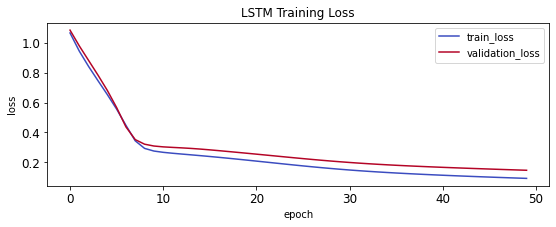

In [27]:
loss_df = pd.DataFrame({
    "train_loss": history.history["loss"],
    "validation_loss":  history.history["val_loss"]
})
loss_df.plot(kind="line", 
        y=["train_loss", "validation_loss"], 
        colormap="coolwarm", 
        figsize=(9, 3), 
        fontsize=12,
        title="LSTM Training Loss",
        xlabel="epoch", 
        ylabel="loss")

In [28]:
for x_validation, y_validation in dataset_validation.take(1):
    print(x_validation.shape, y_validation.shape)

(256, 14, 11) (256,)


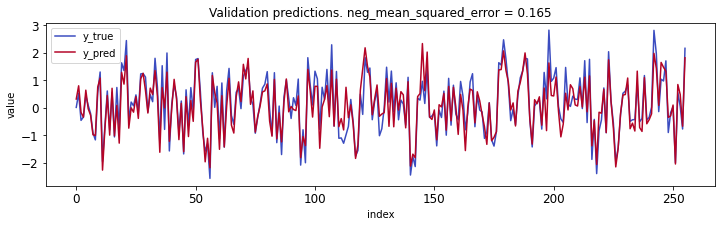

In [29]:
validation_diff = pd.DataFrame({
    "y_pred": model.predict(x_validation).flatten(),
    "y_true": y_validation.numpy()
})
val_mse = round(metrics.mean_squared_error(
    y_true=validation_diff["y_true"],
    y_pred=validation_diff["y_pred"],
), 3)
validation_diff.plot(kind="line", 
        y=["y_true", "y_pred"], 
        colormap="coolwarm", 
        figsize=(12, 3), 
        fontsize=12,
        title=f"Validation predictions. neg_mean_squared_error = {val_mse}",
        xlabel="index", 
        ylabel="value")

In [30]:
dataset_test = df_transform_to_keras_dataset(end_validation_idx, df.shape[0]-1)
for x_test, y_test in dataset_test.take(1):
    print(x_test.shape, y_test.shape)

(815, 12)
(256, 14, 11) (256,)


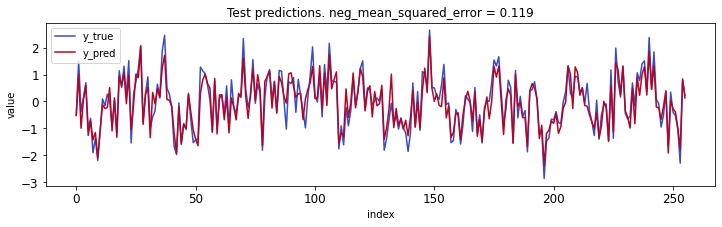

In [31]:
test_diff = pd.DataFrame({
    "y_pred": model.predict(x_test).flatten(),
    "y_true": y_test.numpy()
})
test_mse = round(metrics.mean_squared_error(
    y_true=test_diff["y_true"],
    y_pred=test_diff["y_pred"],
), 3)
test_diff.plot(kind="line", 
        y=["y_true", "y_pred"], 
        colormap="coolwarm", 
        figsize=(12, 3), 
        fontsize=12,
        title=f"Test predictions. neg_mean_squared_error = {test_mse}",
        xlabel="index", 
        ylabel="value")